In [1]:
import pandas as pd 
import numpy as np 
import io

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score as auc 

from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df1 = pd.read_json('data/set1_human.json').sample(5000)
df2 = pd.read_json('data/set1_machine.json')

df3 = pd.read_json('data/set2_human.json')
df4 = pd.read_json('data/set2_machine.json')

df1['class'] = 0
df2['class'] = 1

df3['class'] = 0
df4['class'] = 1

print(df1.shape[0])
print(df2.shape[0])
print(df3.shape[0])
print(df4.shape[0])

print(df1['class'].value_counts())
print(df2['class'].value_counts())
print(df3['class'].value_counts())
print(df4['class'].value_counts())

5000
3500
100
400
0    5000
Name: class, dtype: int64
1    3500
Name: class, dtype: int64
0    100
Name: class, dtype: int64
1    400
Name: class, dtype: int64


In [3]:
train = pd.concat([df1, df2, df3, df4], axis = 'rows')
train['combined'] = (train.prompt+train.txt).map(list)
train = train.drop(['machine_id', 'prompt', 'txt'], axis = 1).reset_index(drop = True)

for i in range(train.shape[0]):
    train['combined'].iloc[i] = map(str, train['combined'].iloc[i]) 
    
train['combined'] = train['combined'].map(' '.join)

LE = LabelEncoder()
train['class'] = LE.fit_transform(train['class'])

train.head()

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,class,combined
0,0,1479 1939 2932 1551 1518 1559 1525 1515 1775 2...
1,0,1502 2726 1567 1478 2185 1500 1602 3133 17 162...
2,0,1542 2644 1491 4547 1543 17 1597 2644 86 1557 ...
3,0,1518 1754 1521 2750 1790 2125 1485 2153 3291 1...
4,0,1602 2756 16 1604 1492 1483 1643 2705 2201 331...


# Testing Setup 

In [4]:
X_train, X_dev, y_train, y_dev = train_test_split(train['combined'], train['class'], 
                                               test_size = 0.25, random_state = 12)

from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.feature_selection import SelectKBest

cv = CountVectorizer()
x_train_count =  cv.fit_transform(X_train)
x_dev_count = cv.transform(X_dev)

num_features = len(cv.get_feature_names_out())
print(num_features)

chi2 = SelectKBest(score_func=chi2, k= 2500)
x_train_chi2 = chi2.fit_transform(x_train_count, y_train)
x_dev_chi2 = chi2.transform(x_dev_count)

3840


# Logistic Regression 

In [5]:
LogReg = LogisticRegression(max_iter = 200000000)
LogReg.fit(x_train_count, y_train)

LogReg_preds = LogReg.predict(x_dev_count)
display(auc(y_dev, LogReg_preds))
classes = [0, 1]
Logreg_confusion_matrix = confusion_matrix(y_dev, LogReg_preds, labels = classes)
Logreg_confusion_matrix

0.868537361776821

array([[1153,  140],
       [ 148,  809]])

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

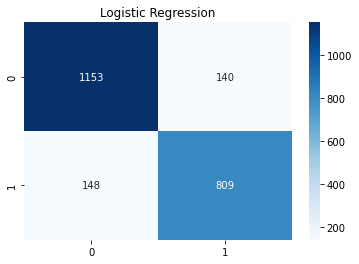

In [6]:
ax = plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression'); 
sns.heatmap(Logreg_confusion_matrix, annot=True, fmt='g', cmap='Blues', ax = ax)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
#plt.savefig('logreg.png')

In [7]:
LogReg = LogisticRegression(max_iter = 200000000)
LogReg.fit(x_train_chi2, y_train)

LogReg_preds = LogReg.predict(x_dev_chi2)
display(auc(y_dev, LogReg_preds))

classes = [0, 1]
Logreg_confusion_matrix = confusion_matrix(y_dev, LogReg_preds, labels = classes)
Logreg_confusion_matrix

0.8606058181624228

array([[1146,  147],
       [ 158,  799]])

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

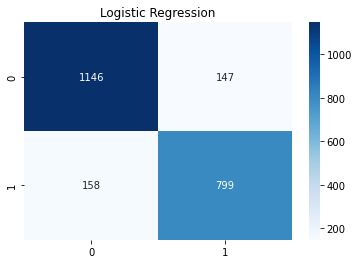

In [8]:
ax = plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression'); 
sns.heatmap(Logreg_confusion_matrix, annot=True, fmt='g', cmap='Blues', ax = ax)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
#plt.savefig('logreg.png')

# XGboost 

In [9]:
xgb = XGBClassifier()

xgb.fit(x_train_count, y_train)

xgb_preds = xgb.predict(x_dev_count)
display(auc(y_dev, xgb_preds))
classes = [0, 1]
xgb_confusion_matrix = confusion_matrix(y_dev, xgb_preds, labels = classes)
xgb_confusion_matrix

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.876403445608982

array([[1122,  171],
       [ 110,  847]])

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

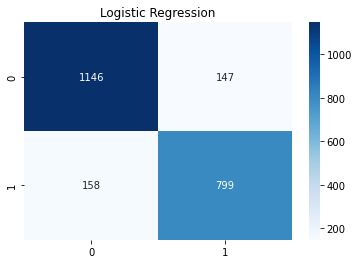

In [10]:
ax = plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression'); 
sns.heatmap(Logreg_confusion_matrix, annot=True, fmt='g', cmap='Blues', ax = ax)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
#plt.savefig('logreg.png')

In [11]:
xgb = XGBClassifier()

xgb.fit(x_train_count, y_train)

xgb_preds = xgb.predict(x_dev_count)
display(auc(y_dev, xgb_preds))
classes = [0, 1]
xgb_confusion_matrix = confusion_matrix(y_dev, xgb_preds, labels = classes)
xgb_confusion_matrix

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.876403445608982

array([[1122,  171],
       [ 110,  847]])

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

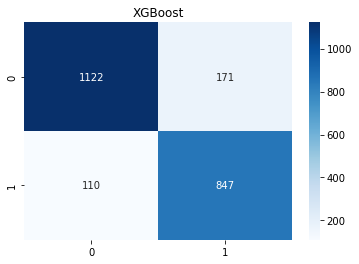

In [12]:
ax = plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('XGBoost'); 
sns.heatmap(xgb_confusion_matrix, annot=True, fmt='g', cmap='Blues', ax = ax)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
#plt.savefig('logreg.png')

In [13]:
xgb = XGBClassifier()

xgb.fit(x_train_chi2, y_train)

xgb_preds = xgb.predict(x_dev_chi2)
display(auc(y_dev, xgb_preds))
classes = [0, 1]
xgb_confusion_matrix = confusion_matrix(y_dev, xgb_preds, labels = classes)
xgb_confusion_matrix

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:17:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8778144675816489

array([[1127,  166],
       [ 111,  846]])

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

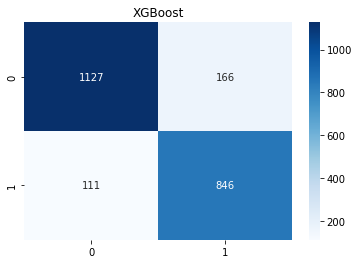

In [14]:
ax = plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('XGBoost'); 
sns.heatmap(xgb_confusion_matrix, annot=True, fmt='g', cmap='Blues', ax = ax)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
#plt.savefig('logreg.png')